In [261]:
from ect import Config ,AntialiasParameters

from ect.filters import utils
from ect.helpers import UnimodalGenerator, Mode, MultimodalGenerator
from ect.tracking import Transformer
from ect.filters import sidelobe, spacenorm, freqnorm
from ect import logpolar_new as logpolar, ilogpolar_new as ilogpolar
from ect import complex_to_hsv, sigmoid

from matplotlib.cm import binary, gist_heat, magma, gray
from matplotlib.axes import Axes
from matplotlib import pyplot as plt
import cv2

from dataclasses import dataclass, field


### Vectors

In [262]:
import numpy as np

def vectors(shape: tuple[int, int], cfg: Config
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Generates base vectors
    for a given shape, in range 
    [1, log(R)] x (0, pi)

    These vectors apply to image folded onto one
    half of plane (x > 0)

    Parameters
    ----------
    shape : tuple[int, int]
        shape of kernel image
    flags : int, optional
        launch configuration, by default ECT_START_PX

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        Tuple of gamma, phi, x and y vectors
    '''

    P, R = shape

    gamma = np.linspace(-1, 1, 2*R, endpoint=False) * np.log(R)
    phi = np.linspace(0 ,1, P, endpoint=False) * 2*np.pi
    phi -= cfg.start_angle_rad

    gammas, phis = np.meshgrid(gamma, phi)
    xs = np.exp(gammas) * np.cos(phis)    
    ys = np.exp(gammas) * np.sin(phis)

    return gammas, phis, xs, ys

### utils

In [263]:
## new utils

import numpy as np

def xcorr(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    '''
    Calculates 2D cross-correlation between two ndarrays
    using following equation:

    xcorr(a, b) = F(A)' * F(B)

    where F stands for Fourier transform
    
    Parameters
    ----------
    A, B : np.ndarray
        Input arrays

    Returns
    -------
    np.ndarray
        Cross-correlation between two arrays
    '''
    A_t = np.fft.fft2(A, axes=(0, 1))
    B_t = np.fft.fft2(B, axes=(0, 1))
    out_t = np.conjugate(A_t) * B_t
    return np.fft.ifft2(out_t, axes=(0,1))


def antialias(
    kernel: np.ndarray, 
    params: list[AntialiasParameters],
    ) -> np.ndarray:
    '''
    Applies antialiasing filter to a kernel

    Parameters
    ----------
    kernel : np.ndarray
        _description_
    cfg: Config
        ECT library launch configuration
        
    Returns
    -------
    np.ndarray
        Kernel with applied antialiasing
    '''
    for p in params:  
        filt = sigmoid(1/p.slope*(p.threshold-p.factor*abs(p.vector)))
        kernel *= filt

    return kernel


def mod_image(
    image: np.ndarray, 
    cfg: Config):
    '''
    Prepares imadd

    Parameters
    ----------
    image : np.ndarray
        _description_
    ect_offset : int
        _description_
    flags : int, optional
        _description_, by default ECT_OMIT_ORIGIN | ECT_START_PX

    Returns
    -------
    _type_
        _description_
    '''
    if cfg.transform == "ect":
        offset = cfg.offset_value_px
        other_offset = cfg.ect_offset_value_px
        ect_factor = 1
    elif cfg.transform == "iect":
        offset = cfg.ect_offset_value_px
        other_offset = cfg.offset_value_px
        ect_factor = -1

    P, R = image.shape[:2]
    image_padded = np.zeros((P, 2*R), dtype=complex)

    rhos, _, xs, _ = vectors((P, R), cfg)
    rhos = rhos[:, R:]
    xs = xs[:, R:] #+ offset

    offset_bool: np.ndarray = (xs > 0).astype(int) 
    off: np.ndarray = (offset_bool*2 - 1) * offset
    xs += off

    if cfg.mode == "offset":
        image_padded[:P, :R] = np.conjugate(image) * \
            np.exp(2*rhos - ect_factor*2*np.pi*1j*other_offset*xs/R)
    elif cfg.mode == "omit":
        image_padded[:P, :R] = np.conjugate(image) * np.exp(2*rhos)
    else:
        raise AttributeError('logpolar mode not in ["offset", "omit"]')

    return image_padded


def shift(image: np.ndarray, cfg: Config) -> np.ndarray:

    if cfg.transform == "ect":
        offset = cfg.offset_value_px
        other_offset = cfg.ect_offset_value_px
        ect_factor = 1
    elif cfg.transform == "iect":
        offset = cfg.ect_offset_value_px
        other_offset = cfg.offset_value_px
        ect_factor = -1

    P, R = image.shape[:2]
    _, _, xs, _ = vectors((P, R), cfg)
    xs -= other_offset
    xs = xs[:, R:]

    return np.exp(ect_factor*2*np.pi*1j*offset*xs/R)

### fect

In [264]:
import cv2
import numpy as np

# from ..configurators import Config, AntialiasParameters
# from .utils_new import (
#     antialias, 
#     mod_image, 
#     xcorr, 
#     shift,
#     fold_logpolar,
#     unfold_logpolar)

# from ..helpers import vectors

def transform(inp: np.ndarray, cfg: Config) -> np.ndarray:
    if cfg.transform == "ect":
        ect_factor = 1
    elif cfg.transform == "iect":
        ect_factor = -1

    P, R = inp.shape[:2]
    _, _, xs, ys = vectors((P, R), cfg)
    kernel = np.exp(2 * np.pi * 1j * xs * ect_factor)
    
    if cfg.antialias:
        cfg.antialias_params = _antialias(xs, ys, (P, R), cfg.antialias_factors)
        kernel = antialias(kernel, cfg.antialias_params)

    image_padded = mod_image(inp, cfg)
    out = xcorr(image_padded, kernel)
    out = out[:, :R]
    return shift(inp, cfg) * out if cfg.mode == "offset" else out


def _antialias(xs, ys, dsize, factors) -> list[AntialiasParameters]:
    return [
        AntialiasParameters(factor=factors[0], threshold=np.log(dsize[1]), vector=xs),
        AntialiasParameters(factor=factors[1], threshold=np.pi, vector=ys)
    ]


def fect(
    image: cv2.Mat | np.ndarray,
    cfg: Config
    ) -> cv2.Mat:
    '''
    Implementation of Fast ECT O(n^2*logn)
    '''
    cfg.validate()
    cfg.transform = "ect"
    # image = fold_logpolar(image)
    P, _ = image.shape
    return transform(image, cfg)

def ifect(
    ect: cv2.Mat,
    cfg: Config
) -> cv2.Mat:
    '''
    Implementation of Inverse FECT O(n^2)
    '''
    cfg.validate()
    cfg.transform = "iect"
    return transform(ect, cfg)


### tests

In [265]:
CART_XLABEL = 'x'
CART_YLABEL = 'y'
CART_TICKS = [x for x in range(0, 501, 100)]


LOG_RLABEL = '$\\rho$'
LOG_PLABEL = '$\\phi$'
LOG_RTICKS = [x for x in range(0, 201, 50)]
LOG_PTICKS = [x for x in range(0, 629, 157)]


def display_fect(
    cart_image: np.ndarray, 
    logpolar_image: np.ndarray, 
    logpolar_transform: np.ndarray = None,
    cart_transform: np.ndarray = None
) -> None:

    fig, axd = plt.subplot_mosaic(
        [['cartimg', 'logimg', 'logect', 'cartect']],
        figsize = (15, 5),
        width_ratios=[1, 0.4, 0.4, 1]
    )    

    ax: Axes = axd['cartimg']
    ax.imshow(cart_image, cmap=binary)
    ax.set_title("Obraz wejściowy:\nwspółrzędne kartezjańskie")
    ax.set_xlabel(CART_XLABEL)
    ax.set_ylabel(CART_YLABEL)
    # ax.set_xticks(CART_TICKS)
    # ax.set_yticks(CART_TICKS)

    ax: Axes = axd['logimg']
    ax.imshow(logpolar_image, cmap=binary)
    ax.set_title("Obraz wejściowy:\nwspółrzędne\nlogarytmiczno-polarne")
    ax.set_xlabel(LOG_RLABEL)
    ax.set_ylabel(LOG_PLABEL)
    # ax.set_xticks(LOG_RTICKS)
    # ax.set_yticks(LOG_PTICKS)

    ax: Axes = axd['cartect']
    ax.imshow(cart_transform)
    ax.set_title("Transformata FECT obrazu:\nwspółrzędne kartezjańskie")
    ax.set_xlabel('$u$')
    ax.set_ylabel('$v$')
    # ax.set_xticks(CART_TICKS)
    # ax.set_yticks(CART_TICKS)

    ax: Axes = axd['logect']
    ax.imshow(logpolar_transform)
    ax.set_title("Transformata FECT \n obrazu")
    ax.set_xlabel('$\\gamma$')
    ax.set_ylabel('$\\theta$')
    # ax.set_xticks(LOG_RTICKS)
    # ax.set_yticks(LOG_PTICKS)

def rgb(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image.astype(np.float32), cv2.COLOR_GRAY2RGB)


In [266]:
@dataclass(slots=True)
class FECTTransformer(Transformer):
    cfg: Config
    dsize: tuple[int, int]
    sidelobe: np.ndarray = field(init=False)
    snf: np.ndarray = field(init=False)
    fnf: np.ndarray = field(init=False)

    def __post_init__(self):
        self.sidelobe = sidelobe(self.dsize, self.cfg)
        self.fnf = freqnorm(self.dsize, self.cfg)
        self.snf = spacenorm(self.dsize, self.cfg)


    def transform(self, inp: np.ndarray, **kwargs) -> np.ndarray:
        cx, cy = inp.shape[0]//2, inp.shape[1]//2
        radius = min(inp.shape)//2

        lp = kwargs.get("logpolar")
        if lp is True or lp is None:
            inp = logpolar(inp, (cx, cy), self.dsize, radius, self.cfg)
            inp *= self.sidelobe

        out = fect(inp, self.cfg)
        out *= self.fnf

        return out
    
    def invert(self, inp: np.ndarray, **kwargs) -> np.ndarray:
        dsize = (200, 200)
        radius = 100

        inv = ifect(inp, self.cfg)
        inv *= self.snf

        lp = kwargs.get("logpolar")
        if lp is True or lp is None:
            inv = ilogpolar(inv, dsize, radius, self.cfg)

        return inv

2024-06-13 02:13:47.684 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=0.0
2024-06-13 02:13:47.688 | DEBUG    | ect.maps.logpolar_new:logpolar:62 - Applying bilinear pixel mapping
2024-06-13 02:13:47.718 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=0.0
2024-06-13 02:13:47.723 | DEBUG    | ect.maps.logpolar_new:logpolar:62 - Applying bilinear pixel mapping
2024-06-13 02:13:47.758 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:78 - Running logpolar transform in offset mode
2024-06-13 02:13:47.775 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:94 - Applying bilinear pixel mapping


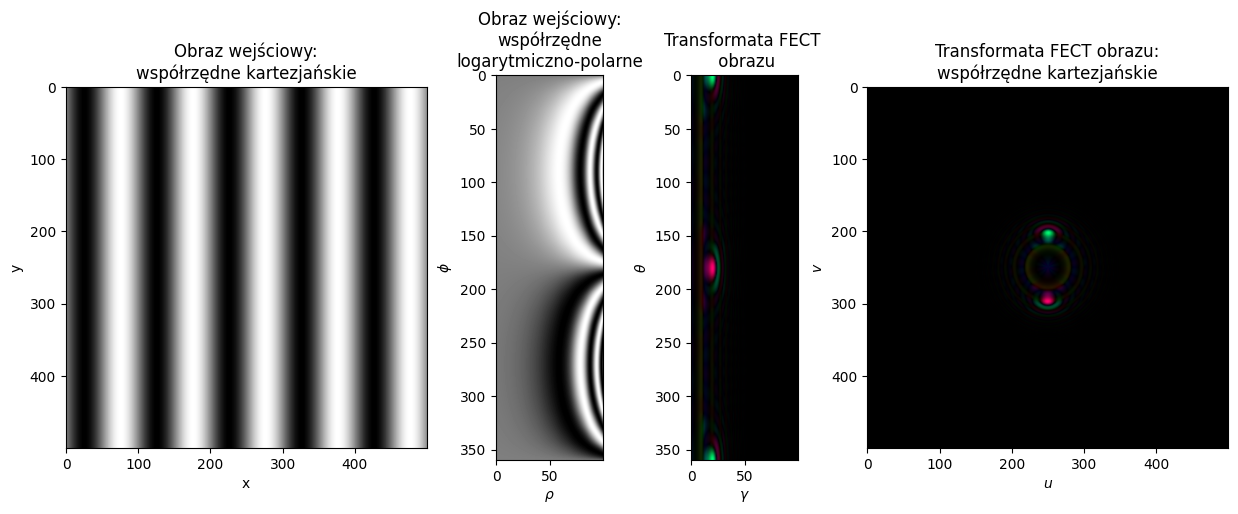

In [267]:
DSIZE = (360,100)
CFG = Config(ect_offset_value_px=0, offset_value_px=0)

SINGLE_MODE = [Mode(100, 0)]
MULTI_MODE = [Mode(50, 90, 3), Mode(50, 45, 1), Mode(50, 135, 1)]
OFFSET = 10

gen = MultimodalGenerator(SINGLE_MODE, dsize=DSIZE, offset=CFG.offset_value_px)
gen_cart = MultimodalGenerator(SINGLE_MODE, dsize=DSIZE, logpolar=False, offset=CFG.offset_value_px)

tr = FECTTransformer(cfg=CFG, dsize=DSIZE)


cart_img = gen_cart.generate()
log_img = gen.generate()

log_ect = tr.transform(cart_img)
log_ect_d = complex_to_hsv(log_ect)

ilp = lambda x: ilogpolar(x, (500, 500), 5, Config(offset_value_px=0))

cart_ect = ilp(log_ect)
cart_ect_d = complex_to_hsv(cart_ect)

display_fect(cart_img, log_img, log_ect_d, cart_ect_d)

### vectors

2024-06-13 02:13:48.957 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=5.0
2024-06-13 02:13:48.961 | DEBUG    | ect.maps.logpolar_new:logpolar:62 - Applying bilinear pixel mapping


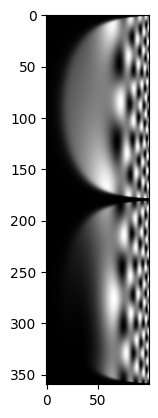

In [268]:
DSIZE = (360,100)
CFG: Config = Config(
    ect_offset_value_px=0, 
    offset_value_px=5,
    # mode="offset",
    # antialias_factors=[0,0]
    )


# SINGLE_MODE = [Mode(50, 90)]
# MULTI_MODE = [Mode(50, 90, 3)]
MULTI_MODE = [Mode(50, 0, 3), Mode(50, 60, 3), Mode(50, 120, 3)]

g = MultimodalGenerator(MULTI_MODE, dsize=DSIZE, offset=CFG.offset_value_px)
img = g.generate()

plt.imshow(img, gray)

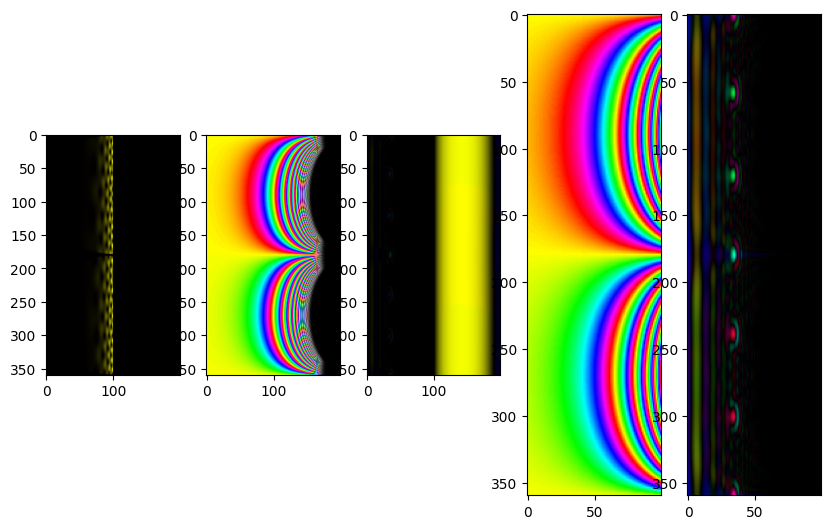

In [269]:
# from ect import vectors
# from ect.transforms.utils_new import antialias, mod_image, xcorr, shift

rhos, phis, xs, ys = vectors(DSIZE, CFG)

kernel = np.exp(2 * np.pi * 1j * xs)

antialias_params = _antialias(xs, ys, DSIZE, CFG.antialias_factors)
kernel = antialias(kernel, antialias_params)

imod = mod_image(img, CFG)
xc = xcorr(imod, kernel)

sh = shift(img, CFG)
# sh = np.ones_like(img)
out = sh * xc[:DSIZE[0], :DSIZE[1]]

rhos, phis, xs, ys = vectors(DSIZE, CFG)


plt.figure(figsize=(10, 8))

plt.subplot(1, 5, 1)
plt.imshow(complex_to_hsv(imod), gist_heat)

plt.subplot(1, 5, 2)
plt.imshow(complex_to_hsv(kernel), gist_heat)

plt.subplot(1, 5, 3)
plt.imshow(complex_to_hsv(xc), gist_heat)

plt.subplot(1, 5, 4)
plt.imshow(complex_to_hsv(sh), gist_heat)

plt.subplot(1,5,5)
plt.imshow(complex_to_hsv(out))

# plt.imshow(complex_to_hsv(kernel))

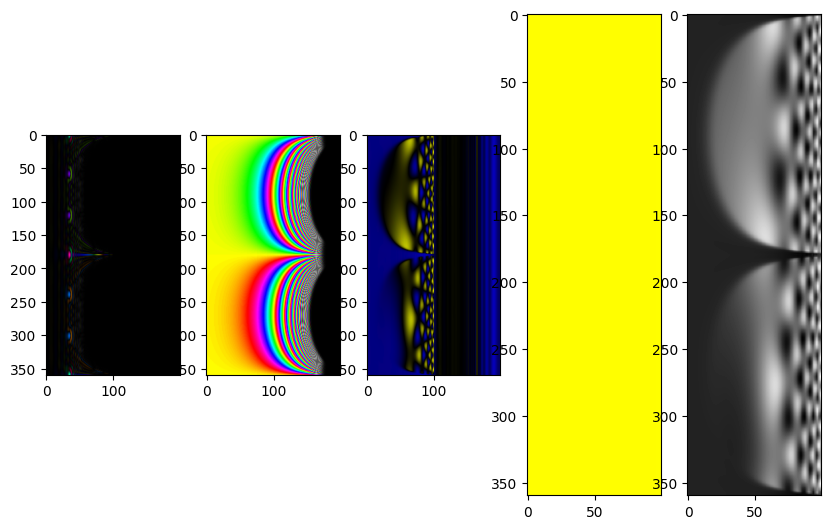

In [270]:
CFG.transform='iect'

rhos, phis, xs, ys = vectors(DSIZE, CFG)

kernel = np.exp(-2 * np.pi * 1j * xs)

antialias_params = _antialias(xs, ys, DSIZE, CFG.antialias_factors)
kernel = antialias(kernel, antialias_params)

imod = mod_image(out, CFG)
xc = xcorr(imod, kernel)

sh = shift(img, CFG)
out = sh * xc[:DSIZE[0], :DSIZE[1]]

rhos, phis, xs, ys = vectors(DSIZE, CFG)


plt.figure(figsize=(10, 8))

plt.subplot(1, 5, 1)
plt.imshow(complex_to_hsv(imod), gist_heat)

plt.subplot(1, 5, 2)
plt.imshow(complex_to_hsv(kernel), gist_heat)

plt.subplot(1, 5, 3)
plt.imshow(complex_to_hsv(xc), gist_heat)

plt.subplot(1, 5, 4)
plt.imshow(complex_to_hsv(sh), gist_heat)

plt.subplot(1,5,5)
plt.imshow(np.real(out), gray)

In [271]:
from ect.optimization import snr

-12.568473830245185

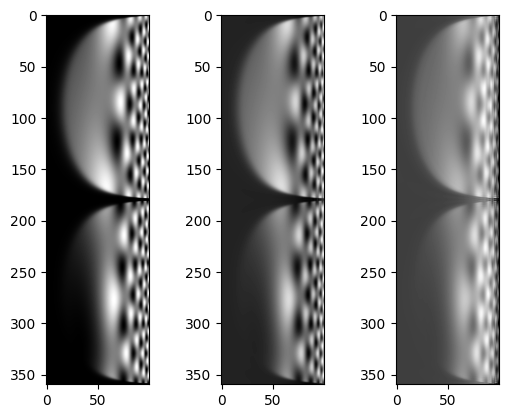

In [272]:

plt.subplot(1, 3, 1)
plt.imshow(img, gray)

plt.subplot(1, 3, 2)
inv = np.real(out)
inv -= inv.min().min()
inv = cv2.normalize(inv, cv2.NORM_L2)
plt.imshow(inv, gray)

plt.subplot(1, 3, 3)
img = cv2.normalize(img, cv2.NORM_L2)
plt.imshow(img - inv, gray)


snr(inv, img)

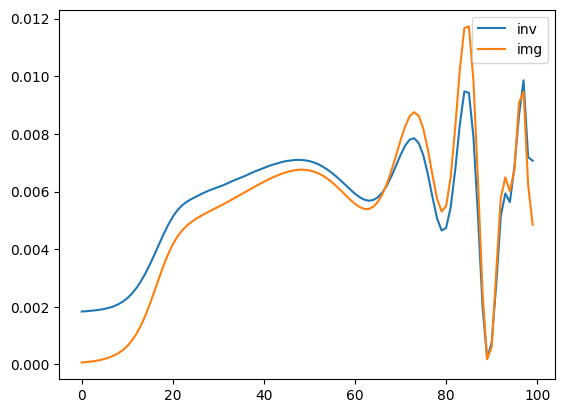

In [273]:
plt.plot(inv[100,:])
plt.plot(img[100,:])
plt.legend(["inv", "img"])